In [1]:
import os
import pickle
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_context('notebook', font_scale=2)

os.chdir("/gscratch/rao/aresf/Code/STSPNet/")

from analysis_utils import *
from utilities import *
from models import *
from stimulus import *

import wandb

In [2]:
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: Currently logged in as: fishysoup. Use `wandb login --relogin` to force relogin


True

In [3]:
# Defaults
image_set = 'A'
noise_std = 0.5
hidden_dim = 16
l2_penalty = 0.001
seq_length = 50000
delay_dur = 500
batch_size = 128
epochs = 2000
log_interval = 100
omit_frac = 0.05
pos_weight = 5

In [4]:
# hyperparams
sweep_config = {
    'method': 'bayes',
    'metric': {
        'name': 'adapt_slope',
        'goal': 'minimize'
    },
    'parameters': {
        'syn_tau': {
            'distribution': 'uniform',
            'min': 6,
            'max': 20,
        },
        'patience': {
            'values':  [5, 10, 15, 20]
        },
        'dprime_targ': {
            'distribution': 'uniform',
            'min': 1.0,
            'max': 2.0,
        },
        
    }
}

In [5]:
def train(device, train_generator, model, criterion, optimizer):
    """
    Train model
    """
    model.train()

    # Get inputs and labels
    inputs, inputs_prev, labels, _, mask, _ = train_generator.generate_batch()
    # Send to device
    inputs = torch.from_numpy(inputs).to(device)
    inputs_prev = torch.from_numpy(inputs_prev).to(device)
    labels = torch.from_numpy(labels).to(device)
    mask = torch.from_numpy(mask).to(device)

    # Initialize syn_x or hidden state
    model.syn_x = model.init_syn_x(batch_size).to(device)
    # output
    output, hidden, _ = model(inputs)
    # Convert to binary prediction
    output = torch.sigmoid(output)
    pred = torch.bernoulli(output).byte()

    hit_rate, fa_rate = get_hit_false_rate(pred, labels)
    # Compute dprime
    dprime_true = dprime(hit_rate, fa_rate)

    loss = criterion(output, labels.clamp(min=0))
    # Apply mask and take mean
    loss = (loss * mask).mean()

    # L2 loss on hidden unit activations
    L2_loss = hidden.pow(2).mean()
    loss += l2_penalty * L2_loss
    loss.backward()
    optimizer.step()
    return loss.item(), dprime_true.item()


def test(device, test_generator, model):
    """
    Test model, get predictions and plot confusion matrix
    """
    model.eval()

    with torch.no_grad():
        # Get inputs and labels
        inputs, inputs_prev, labels, image,  _, omit = test_generator.generate_batch()

        # Send to device
        inputs = torch.from_numpy(inputs).to(device)
        inputs_prev = torch.from_numpy(inputs_prev).to(device)
        labels = torch.from_numpy(labels).to(device)

        # Initialize syn_x or hidden state
        model.syn_x = model.init_syn_x(batch_size).to(device)

        output, hidden, input_syn = model(inputs)

    # Convert to binary prediction
    output = torch.sigmoid(output)
    pred = torch.bernoulli(output).byte()

    # Compute hit rate and false alarm rate
    hit_rate, fa_rate = get_hit_false_rate(pred, labels)
    # Compute dprime
    dprime_true = dprime(hit_rate, fa_rate)

    adapt_slope = get_adapt_slope(input_syn.cpu(), labels.cpu(), image)
    
    return dprime_true.item(), hit_rate, fa_rate, input_syn, hidden, output, pred, image, labels, omit, adapt_slope

def get_adapt_slope(input_act, labels, image):
    img_idx = [np.argwhere(image == i) for i in range(8)]
    input_act_image = [
        input_act[i[:, 0], i[:, 1]].mean(axis=0) for i in img_idx]
    pref_image = np.argmax(np.stack(input_act_image), axis=0)
    go_trial = np.zeros((input_act.shape[2], 19))
    for cell in range(go_trial.shape[0]):
        idx = np.argwhere((labels.cpu().numpy().squeeze() == 1) &
                          (image == pref_image[cell]))
        go_trials = []
        for trial in idx:
            trial_chunk = input_act[trial[0],
                                    (trial[1]-9):(trial[1]+9+1), cell]
            if trial_chunk.shape[0] == go_trial.shape[1]:
                go_trials.append(trial_chunk)
        go_trial[cell, :] = np.stack(go_trials).mean(axis=0)

    x = np.arange(4)
    # starting at event, 3::
    y = go_trial[:, ::3].mean(axis=0)[3::]
    g, _ = np.polyfit(x, y, 1)
    return g


In [6]:
def run_model(config=None):
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    # Set random seed
    # Create train stimulus generator
    train_generator = StimGenerator(image_set=image_set, seed=1,
                                    batch_size=batch_size, seq_length=seq_length,
                                    delay_dur=delay_dur)

    # Get input dimension of feature vector
    input_dim = len(train_generator.feature_dict[0])

    # Create model
    with wandb.init(config=config):
        config = wandb.config
        
        model = STPNet(input_dim=input_dim,
                        hidden_dim=hidden_dim,
                        syn_tau=config.syn_tau,
                        noise_std=noise_std).to(device)

        # Define loss function
        criterion = torch.nn.BCEWithLogitsLoss(
            reduction='none', pos_weight=torch.tensor([pos_weight]).to(device))
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

        # Initialize tracking variables
        loss_list = []
        dprime = 0
        dprime_list = []
        wait = 0

        for epoch in range(1, epochs + 1):
            # Train model
            loss, dprime = train(device, train_generator,
                                model, criterion, optimizer)

            loss_list.append(loss)
            dprime_list.append(dprime)

            if epoch % log_interval == 0:
                # Print current progress
                print("Epoch: {}  loss: {:.4f}  dprime: {:.2f}".format(
                    epoch, loss, dprime))

            if dprime < config.dprime_targ:
                # Reset wait count
                wait = 0
            else:
                # Increase wait count
                wait += 1
                # Stop training after wait exceeds patience
                if wait >= config.patience:
                    break

        test_generator = StimGenerator(image_set=image_set, seed=1,
                                    batch_size=batch_size, seq_length=seq_length,
                                    delay_dur=delay_dur, omit_frac=omit_frac)

        dprime_true, hit_rate, fa_rate, input_syn, hidden, output, pred, image, labels, omit, adapt_slope = test(device, test_generator, model)
        wandb.log({"adapt_slope": adapt_slope, 'loss': loss, 'dprime_true': dprime_true})
        # Save trained model
        save_dir = './PARAM/wandb/STPNet/model_train'
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        save_path = save_dir+'/syn_tau_{}_patience_{}_dprime_targ_{}.pt'.format(config.syn_tau, config.patience, config.dprime_targ)
        torch.save({'epoch': epoch,
                    'loss': loss_list,
                    'dprime': dprime_list,
                    'state_dict': model.state_dict()}, save_path)

In [7]:
sweep_id = wandb.sweep(sweep_config, project="STPNet_bayes_sweep")

Create sweep with ID: uq4nb1mu
Sweep URL: https://wandb.ai/fishysoup/STPNet_bayes_sweep/sweeps/uq4nb1mu


In [8]:
wandb.agent(sweep_id, run_model, count=30)

wandb: Agent Starting Run: jgl98wvg with config:
wandb: 	dprime_targ: 1.1511708378656067
wandb: 	patience: 15
wandb: 	syn_tau: 14.336579435975835
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Epoch: 100  loss: 0.3583  dprime: 0.49
Epoch: 200  loss: 0.3310  dprime: 1.26


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


adapt_slope,▁
dprime_true,▁
loss,▁
adapt_slope,-0.01232
dprime_true,1.6843
loss,0.32795


wandb: Agent Starting Run: 4x8kp9ze with config:
wandb: 	dprime_targ: 1.8685218547009703
wandb: 	patience: 5
wandb: 	syn_tau: 6.659931008576023
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Epoch: 100  loss: 0.3623  dprime: 0.39
Epoch: 200  loss: 0.3436  dprime: 0.78
Epoch: 300  loss: 0.3333  dprime: 1.46
Epoch: 400  loss: 0.3311  dprime: 1.44
Epoch: 500  loss: 0.3296  dprime: 1.81
Epoch: 600  loss: 0.3276  dprime: 1.32
Epoch: 700  loss: 0.3312  dprime: 1.97
Epoch: 800  loss: 0.3299  dprime: 1.50
Epoch: 900  loss: 0.3286  dprime: 1.65
Epoch: 1000  loss: 0.3256  dprime: 1.51
Epoch: 1100  loss: 0.3246  dprime: 1.43


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


adapt_slope,▁
dprime_true,▁
loss,▁
adapt_slope,-0.02164
dprime_true,2.13518
loss,0.32596


wandb: Agent Starting Run: wspf2myz with config:
wandb: 	dprime_targ: 1.5648806153697297
wandb: 	patience: 10
wandb: 	syn_tau: 18.114260379158836
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Epoch: 100  loss: 0.3568  dprime: 0.68
Epoch: 200  loss: 0.3303  dprime: 1.40


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


adapt_slope,▁
dprime_true,▁
loss,▁
adapt_slope,-0.00917
dprime_true,1.55076
loss,0.31886


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 22esl7ey with config:
wandb: 	dprime_targ: 1.8532422983881989
wandb: 	patience: 5
wandb: 	syn_tau: 7.07717223517365
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Epoch: 100  loss: 0.3552  dprime: 0.41
Epoch: 200  loss: 0.3347  dprime: 1.17
Epoch: 300  loss: 0.3318  dprime: 1.41
Epoch: 400  loss: 0.3314  dprime: 1.48
Epoch: 500  loss: 0.3272  dprime: 1.83
Epoch: 600  loss: 0.3278  dprime: 2.28
Epoch: 700  loss: 0.3286  dprime: 1.43


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


adapt_slope,▁
dprime_true,▁
loss,▁
adapt_slope,-0.01809
dprime_true,1.79797
loss,0.32816


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: x8rn10kh with config:
wandb: 	dprime_targ: 1.2137866407896234
wandb: 	patience: 10
wandb: 	syn_tau: 16.370354425057506
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Epoch: 100  loss: 0.3587  dprime: 0.54
Epoch: 200  loss: 0.3297  dprime: 1.24


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


adapt_slope,▁
dprime_true,▁
loss,▁
adapt_slope,-0.01871
dprime_true,1.26997
loss,0.33036


wandb: Agent Starting Run: rqxfoafq with config:
wandb: 	dprime_targ: 1.0580389778322443
wandb: 	patience: 5
wandb: 	syn_tau: 9.293398135137029
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Epoch: 100  loss: 0.3558  dprime: 0.29


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


adapt_slope,▁
dprime_true,▁
loss,▁
adapt_slope,-0.01634
dprime_true,1.21117
loss,0.3359


wandb: Agent Starting Run: asfoeguq with config:
wandb: 	dprime_targ: 1.1480424991541691
wandb: 	patience: 10
wandb: 	syn_tau: 6.3510705719105855
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Epoch: 100  loss: 0.3647  dprime: 0.15
Epoch: 200  loss: 0.3437  dprime: 0.98
Epoch: 300  loss: 0.3456  dprime: 1.17


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


adapt_slope,▁
dprime_true,▁
loss,▁
adapt_slope,-0.01008
dprime_true,1.07832
loss,0.34221


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: l8qlbzhy with config:
wandb: 	dprime_targ: 1.8796922228177897
wandb: 	patience: 10
wandb: 	syn_tau: 12.93406474373937
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Epoch: 100  loss: 0.3548  dprime: 0.48
Epoch: 200  loss: 0.3293  dprime: 1.31
Epoch: 300  loss: 0.3208  dprime: 1.75


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


adapt_slope,▁
dprime_true,▁
loss,▁
adapt_slope,-0.01542
dprime_true,1.71681
loss,0.31796


wandb: Agent Starting Run: ghxe7t1p with config:
wandb: 	dprime_targ: 1.4287244433929311
wandb: 	patience: 10
wandb: 	syn_tau: 18.280501130382543
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Epoch: 100  loss: 0.3619  dprime: 0.29
Epoch: 200  loss: 0.3329  dprime: 1.26


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


adapt_slope,▁
dprime_true,▁
loss,▁
adapt_slope,-0.02125
dprime_true,1.57775
loss,0.32282


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: l5ynvss5 with config:
wandb: 	dprime_targ: 1.563599186544722
wandb: 	patience: 10
wandb: 	syn_tau: 19.307381922422685
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Epoch: 100  loss: 0.3541  dprime: 0.59
Epoch: 200  loss: 0.3225  dprime: 1.61


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


adapt_slope,▁
dprime_true,▁
loss,▁
adapt_slope,-0.0064
dprime_true,1.6547
loss,0.32105


wandb: Agent Starting Run: mvtfwatg with config:
wandb: 	dprime_targ: 1.8223509541756535
wandb: 	patience: 10
wandb: 	syn_tau: 10.980488842135244
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Epoch: 100  loss: 0.3486  dprime: 0.63
Epoch: 200  loss: 0.3270  dprime: 1.20
Epoch: 300  loss: 0.3235  dprime: 1.77


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


adapt_slope,▁
dprime_true,▁
loss,▁
adapt_slope,-0.01868
dprime_true,2.0419
loss,0.32069


wandb: Agent Starting Run: atj75fri with config:
wandb: 	dprime_targ: 1.910074650532582
wandb: 	patience: 5
wandb: 	syn_tau: 10.133528947570252
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Epoch: 100  loss: 0.3566  dprime: 0.26
Epoch: 200  loss: 0.3318  dprime: 1.22
Epoch: 300  loss: 0.3243  dprime: 1.85
Epoch: 400  loss: 0.3198  dprime: 1.90


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


adapt_slope,▁
dprime_true,▁
loss,▁
adapt_slope,-0.01548
dprime_true,1.79182
loss,0.32404


wandb: Agent Starting Run: ifsgijxj with config:
wandb: 	dprime_targ: 1.214255419072401
wandb: 	patience: 20
wandb: 	syn_tau: 6.819003956072268
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Epoch: 100  loss: 0.3598  dprime: 0.24
Epoch: 200  loss: 0.3395  dprime: 0.94
Epoch: 300  loss: 0.3328  dprime: 1.43


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


adapt_slope,▁
dprime_true,▁
loss,▁
adapt_slope,-0.01394
dprime_true,1.59139
loss,0.3331


wandb: Agent Starting Run: sxu0n6bq with config:
wandb: 	dprime_targ: 1.2793377733951314
wandb: 	patience: 15
wandb: 	syn_tau: 19.17758862211255
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Epoch: 100  loss: 0.3506  dprime: 0.67


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


adapt_slope,▁
dprime_true,▁
loss,▁
adapt_slope,-0.00818
dprime_true,1.59464
loss,0.32359


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: d2fe9k67 with config:
wandb: 	dprime_targ: 1.0606250376023652
wandb: 	patience: 10
wandb: 	syn_tau: 9.360080609960852
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Epoch: 100  loss: 0.3527  dprime: 0.41


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


adapt_slope,▁
dprime_true,▁
loss,▁
adapt_slope,-0.01538
dprime_true,1.37922
loss,0.33292


wandb: Agent Starting Run: s3erqb11 with config:
wandb: 	dprime_targ: 1.3441093660711296
wandb: 	patience: 5
wandb: 	syn_tau: 10.855362539081362
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Epoch: 100  loss: 0.3525  dprime: 0.61
Epoch: 200  loss: 0.3301  dprime: 1.27


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


adapt_slope,▁
dprime_true,▁
loss,▁
adapt_slope,-0.02524
dprime_true,1.44888
loss,0.32675


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 1e0owt9y with config:
wandb: 	dprime_targ: 1.5237850412373328
wandb: 	patience: 10
wandb: 	syn_tau: 14.271247885920715
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Epoch: 100  loss: 0.3597  dprime: 0.38
Epoch: 200  loss: 0.3309  dprime: 1.13


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


adapt_slope,▁
dprime_true,▁
loss,▁
adapt_slope,-0.01235
dprime_true,1.75376
loss,0.32258


wandb: Agent Starting Run: nh7c6n49 with config:
wandb: 	dprime_targ: 1.0487150681493191
wandb: 	patience: 5
wandb: 	syn_tau: 14.125345239022527
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Epoch: 100  loss: 0.3552  dprime: 0.53


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


adapt_slope,▁
dprime_true,▁
loss,▁
adapt_slope,-0.01167
dprime_true,1.27076
loss,0.33515


wandb: Agent Starting Run: xigobf95 with config:
wandb: 	dprime_targ: 1.3446151591623718
wandb: 	patience: 15
wandb: 	syn_tau: 14.278222312934904
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Epoch: 100  loss: 0.3587  dprime: 0.42
Epoch: 200  loss: 0.3287  dprime: 1.58


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


adapt_slope,▁
dprime_true,▁
loss,▁
adapt_slope,-0.01262
dprime_true,1.49655
loss,0.32812


wandb: Agent Starting Run: axs17ghw with config:
wandb: 	dprime_targ: 1.454238457663199
wandb: 	patience: 20
wandb: 	syn_tau: 12.951126855317558
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Epoch: 100  loss: 0.3528  dprime: 0.37
Epoch: 200  loss: 0.3272  dprime: 1.52


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


adapt_slope,▁
dprime_true,▁
loss,▁
adapt_slope,-0.02162
dprime_true,1.65264
loss,0.32179


wandb: Agent Starting Run: 069tzi5m with config:
wandb: 	dprime_targ: 1.4940866886872626
wandb: 	patience: 20
wandb: 	syn_tau: 15.046041148950453
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Epoch: 100  loss: 0.3594  dprime: 0.54
Epoch: 200  loss: 0.3331  dprime: 1.04
Epoch: 300  loss: 0.3216  dprime: 1.84


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


adapt_slope,▁
dprime_true,▁
loss,▁
adapt_slope,-0.0136
dprime_true,1.86269
loss,0.32092


wandb: Agent Starting Run: b5fnv2ef with config:
wandb: 	dprime_targ: 1.873430567435769
wandb: 	patience: 15
wandb: 	syn_tau: 16.90409651486314
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Epoch: 100  loss: 0.3509  dprime: 0.61
Epoch: 200  loss: 0.3267  dprime: 1.68
Epoch: 300  loss: 0.3201  dprime: 2.02


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


adapt_slope,▁
dprime_true,▁
loss,▁
adapt_slope,-0.00626
dprime_true,2.10386
loss,0.31898


wandb: Agent Starting Run: s80hrg5f with config:
wandb: 	dprime_targ: 1.2203827353229617
wandb: 	patience: 5
wandb: 	syn_tau: 11.132742968868463
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Epoch: 100  loss: 0.3548  dprime: 0.41
Epoch: 200  loss: 0.3317  dprime: 1.31


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


adapt_slope,▁
dprime_true,▁
loss,▁
adapt_slope,-0.01684
dprime_true,1.3336
loss,0.32883


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 2lwzn2fc with config:
wandb: 	dprime_targ: 1.5558101071677173
wandb: 	patience: 15
wandb: 	syn_tau: 18.75583973644259
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Epoch: 100  loss: 0.3540  dprime: 0.60
Epoch: 200  loss: 0.3272  dprime: 1.37


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


adapt_slope,▁
dprime_true,▁
loss,▁
adapt_slope,-0.02431
dprime_true,1.9593
loss,0.31912


wandb: Agent Starting Run: 84rcvdrr with config:
wandb: 	dprime_targ: 1.104769355566002
wandb: 	patience: 5
wandb: 	syn_tau: 18.83833846509546
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Epoch: 100  loss: 0.3580  dprime: 0.48


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


adapt_slope,▁
dprime_true,▁
loss,▁
adapt_slope,-0.01295
dprime_true,1.32704
loss,0.3303


wandb: Agent Starting Run: p7t7hcbk with config:
wandb: 	dprime_targ: 1.452090786043577
wandb: 	patience: 10
wandb: 	syn_tau: 17.602167072473772
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Epoch: 100  loss: 0.3533  dprime: 0.59
Epoch: 200  loss: 0.3259  dprime: 1.61


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


adapt_slope,▁
dprime_true,▁
loss,▁
adapt_slope,-0.00583
dprime_true,1.54057
loss,0.3229


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: dxf81ba6 with config:
wandb: 	dprime_targ: 1.794939590657092
wandb: 	patience: 15
wandb: 	syn_tau: 6.0933077692556825
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Epoch: 100  loss: 0.3546  dprime: 0.15
Epoch: 200  loss: 0.3371  dprime: 1.29
Epoch: 300  loss: 0.3352  dprime: 1.25
Epoch: 400  loss: 0.3301  dprime: 1.37
Epoch: 500  loss: 0.3314  dprime: 1.49
Epoch: 600  loss: 0.3266  dprime: 1.57
Epoch: 700  loss: 0.3279  dprime: 1.65
Epoch: 800  loss: 0.3305  dprime: 1.68
Epoch: 900  loss: 0.3319  dprime: 1.36
Epoch: 1000  loss: 0.3258  dprime: 1.97
Epoch: 1100  loss: 0.3291  dprime: 1.36
Epoch: 1200  loss: 0.3272  dprime: 1.55
Epoch: 1300  loss: 0.3263  dprime: 1.69
Epoch: 1400  loss: 0.3191  dprime: 1.65
Epoch: 1500  loss: 0.3261  dprime: 1.77
Epoch: 1600  loss: 0.3212  dprime: 1.53
Epoch: 1700  loss: 0.3280  dprime: 1.32
Epoch: 1800  loss: 0.3250  dprime: 1.78
Epoch: 1900  loss: 0.3234  dprime: 1.60
Epoch: 2000  loss: 0.3252  dprime: 1.51


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


adapt_slope,▁
dprime_true,▁
loss,▁
adapt_slope,-0.01496
dprime_true,1.5891
loss,0.32524


wandb: Agent Starting Run: hobjmt2u with config:
wandb: 	dprime_targ: 1.4134232216833935
wandb: 	patience: 15
wandb: 	syn_tau: 7.540544199681456
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Epoch: 100  loss: 0.3553  dprime: 0.57
Epoch: 200  loss: 0.3341  dprime: 1.47
Epoch: 300  loss: 0.3301  dprime: 1.65


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


adapt_slope,▁
dprime_true,▁
loss,▁
adapt_slope,-0.01213
dprime_true,1.65564
loss,0.32956


wandb: Agent Starting Run: bcsddszo with config:
wandb: 	dprime_targ: 1.7620732459431356
wandb: 	patience: 20
wandb: 	syn_tau: 17.651926892376125
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Epoch: 100  loss: 0.3487  dprime: 0.61
Epoch: 200  loss: 0.3227  dprime: 1.82


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


adapt_slope,▁
dprime_true,▁
loss,▁
adapt_slope,-0.0061
dprime_true,2.30187
loss,0.31675


wandb: Agent Starting Run: 77f3kgb4 with config:
wandb: 	dprime_targ: 1.2757405980120111
wandb: 	patience: 15
wandb: 	syn_tau: 9.803469253853724
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Epoch: 100  loss: 0.3587  dprime: 0.33
Epoch: 200  loss: 0.3345  dprime: 1.31


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


adapt_slope,▁
dprime_true,▁
loss,▁
adapt_slope,-0.00688
dprime_true,1.61256
loss,0.32983


In [ ]:
for i, syn_tau in enumerate(np.arange(4, 20, 4)):
    !python main.py --model STPNet --noise-std 0.5 --l2-penalty 0.001 --pos-weight 5 --dprime 1.5 --patience 5 --syn-tau {syn_tau} --seed {i + 1}

Epoch: 100  loss: 0.3672  dprime: 0.03
Epoch: 200  loss: 0.3548  dprime: 0.60
Epoch: 300  loss: 0.3424  dprime: 0.74
Epoch: 400  loss: 0.3393  dprime: 0.87
Epoch: 500  loss: 0.3384  dprime: 1.06
Epoch: 600  loss: 0.3336  dprime: 1.26
Epoch: 700  loss: 0.3361  dprime: 1.20
Epoch: 800  loss: 0.3297  dprime: 1.43
Epoch: 900  loss: 0.3283  dprime: 1.23
Epoch: 1000  loss: 0.3274  dprime: 1.45
Epoch: 1100  loss: 0.3238  dprime: 1.62
Epoch: 1200  loss: 0.3245  dprime: 1.42
Epoch: 1300  loss: 0.3201  dprime: 1.56
Epoch: 1400  loss: 0.3202  dprime: 1.60
Epoch: 100  loss: 0.3643  dprime: 0.12
Epoch: 200  loss: 0.3493  dprime: 0.54
Epoch: 300  loss: 0.3388  dprime: 0.80
Epoch: 400  loss: 0.3305  dprime: 1.32
Epoch: 500  loss: 0.3271  dprime: 1.32
Epoch: 600  loss: 0.3239  dprime: 2.01
Epoch: 100  loss: 0.3620  dprime: 0.21
Epoch: 200  loss: 0.3359  dprime: 0.93
Epoch: 300  loss: 0.3225  dprime: 1.36
Epoch: 400  loss: 0.3181  dprime: 1.66
Epoch: 100  loss: 0.3623  dprime: 0.45
Epoch: 200  loss: 0.

In [ ]:
for i, syn_tau in enumerate(np.arange(4, 20, 4)):
    !python experiment.py --model STPNet --model-path ./PARAM/STPNet/model_train_seed_{i+1}.pt --noise-std 0.5 --syn-tau {syn_tau} --omit-frac 0.05 --seed {i+1}

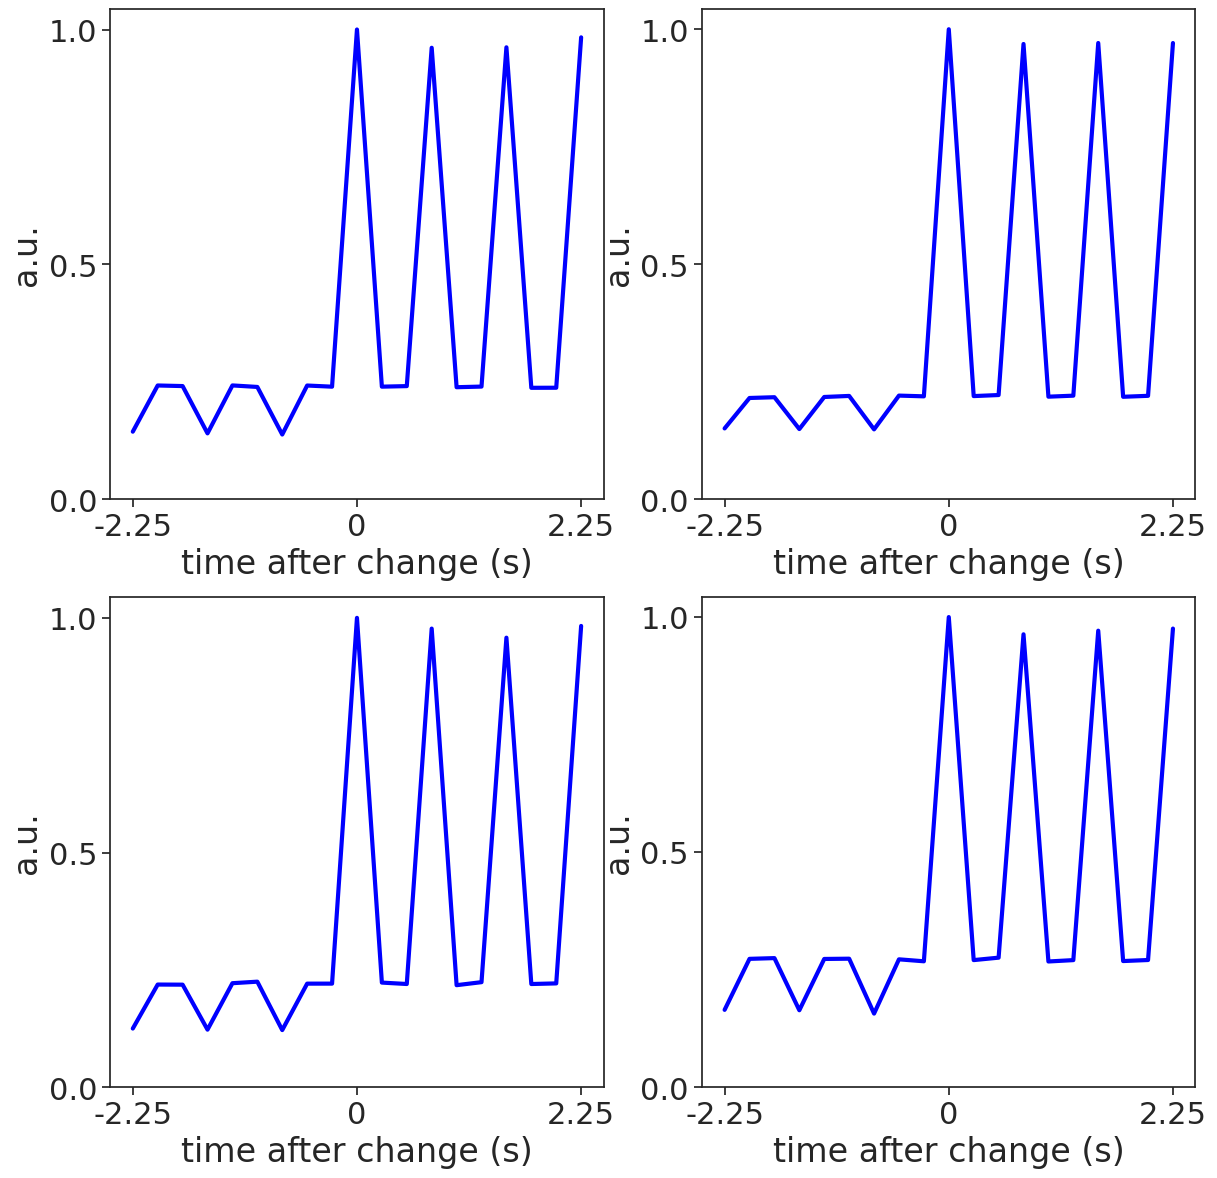

In [ ]:
fig, ax = plt.subplots(2,2, figsize=(14, 14))
sdict = {0: (0, 0), 1: (0, 1), 2: (1, 0), 3: (1, 1)}

for i in range(4):
    result_path = "RESULT/STPNet/STPNet_A_{}.pkl".format(i+1)
    model_data, pref_image = get_acts(result_path)
    go_trial = get_go_trials(model_data, pref_image)
    plot_go_trial(go_trial, ax[sdict[i]])